# Section 11 - Logistic regression

Response $y$ categorical, i.e. prediction task is classification task.

Here: binary classification with $y \in \{0,1\}$.

In [1]:
library(ggplot2)
library(tidyr)
library(magrittr)
library(gridExtra)
library(dplyr)
library(data.table)
library(tidyverse)
library(patchwork)
library(scales)

# install.packages("plotROC")
library(plotROC)
# install.packages("PRROC")
library(PRROC)

options(repr.plot.width = 7, repr.plot.height = 5, repr.plot.res = 100)
options(warn=-1)

file_path <- file.path("/Users", "donatabuozyte", "Downloads", "extdata")


Attaching package: ‘magrittr’

The following object is masked from ‘package:tidyr’:

    extract


Attaching package: ‘dplyr’

The following object is masked from ‘package:gridExtra’:

    combine

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘data.table’

The following objects are masked from ‘package:dplyr’:

    between, first, last

Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ tibble  3.1.5     ✔ purrr   0.3.4
✔ readr   1.3.1     ✔ stringr 1.4.0
✔ tibble  3.1.5     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ data.table::between() masks dplyr::between()
✖ dplyr::combine()      masks gridExtra::combine()
✖ magrittr::extract()   masks tidyr::extract()
✖ dply

In [2]:
# --------------------

## Univariate Example: Predicting Sex Given Height

Classification task: predict student's sex given the student's height.

---

*First attempt*: linear regression.

Assign: 1 = male, 0 = female.

Prediction: returns value of category based on height of student.

Problem: $y$ only defined for 0 and 1, regression line not.

---

*Second attempt*: linear regression, but model proportion of males per height first.

Problems:
1. predictions based can still be outside $[0,1]$.
2. relationship in S-shape, hence not well captured by linear fit.

---

*Third attempt*: linear regression, but rescale response for better linear relationship.

Idea: consider odds for binary $y$ $\frac{P(y)}{1-P(y)}$ instead of probabilities of male per stratum.

Here: population odds $\simeq$ male:female = $\frac{289}{253}$.

Now: odds in logarythmic scale suggests linear relationship. (remark: poor estimation of extreme values, as no males in low and no females in high strata.)

Observation indicate: $\log(\frac{p(male)}{1-p(male)}) \simeq \beta_{0} + \beta_{1} \cdot \mathrm{height}$, similar to logit function $\mathrm{logit}(z) = \log(\frac{z}{1-z})$ for $z \in (0,1)$.

Reverse of logit function: sigmoid (/logistic) function $\sigma(z) = \frac{1}{1+e^{-z}} \in (0,1)$ for $z \in \mathbb{R}$. (point symmetric function around 0!)

---

*Result*: linear relationship found in third attempt!

Problems:
- requires arbitrary binning
- extreme bins cannot be used
- log-odds of more bins better estimates than others -> untertainty should be factored

In [3]:
# load and prepare heights data table

heights <- fread(file.path(file_path, "height.csv")) %>% na.omit() %>%
  .[, sex:=as.factor(toupper(sex))]
heights <- heights[sex %in% c("M", "F")]

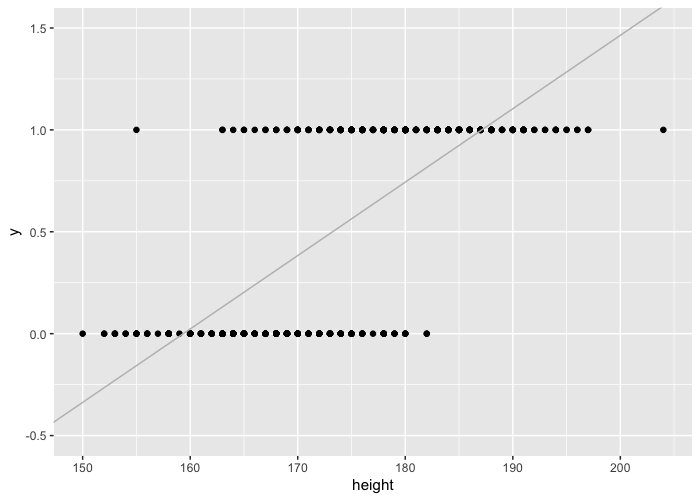

In [4]:
# try linear regression

heights[, y:=as.numeric(sex == "M")]
lm_fit0 <- lm(y~height, data=heights)
ggplot(heights, aes(height, y)) + 
  geom_point() + 
  geom_abline(intercept = lm_fit0$coef[1], slope = lm_fit0$coef[2], col="grey") +
  scale_y_continuous(limits=c(-0.5,1.5))

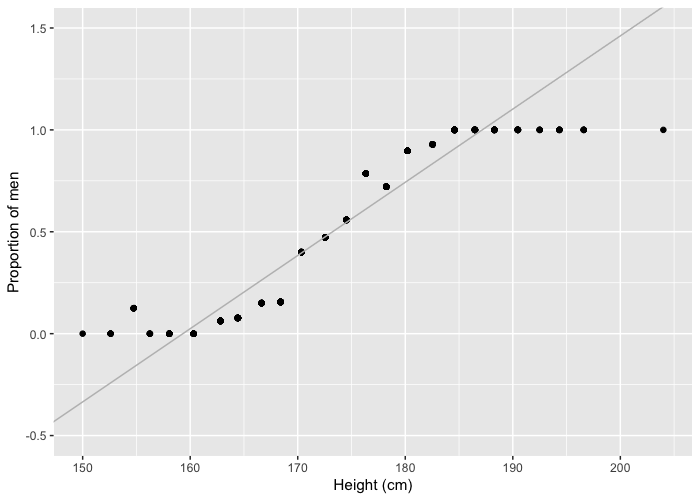

In [5]:
# create 2 cm bins to stratify height
# try linear regression but model proportion of males per height

heights[, height_bins := cut(height, breaks=seq(min(height)-1, max(height), 2))]
heights[, mean_height_bins := mean(height), by=height_bins]
props <- heights[, prop:=mean(sex=="M"), by=height_bins]

lm_fit <- lm(prop ~ height, data=props)

ggplot(props, aes(mean_height_bins, prop)) +
  geom_point() +
  xlab("Height (cm)") +
  ylab("Proportion of men") +
  geom_abline(intercept = lm_fit$coef[1], slope = lm_fit$coef[2], col="grey")  +
  scale_y_continuous(limits=c(-0.5,1.5))

In [6]:
# estimate population odds

table(heights$sex)


  F   M   W   А 
253 289   0   0 

In [7]:
# define odds for each height stratum

heights[, odds := sum(y==1)/sum(y==0), by=height_bins]

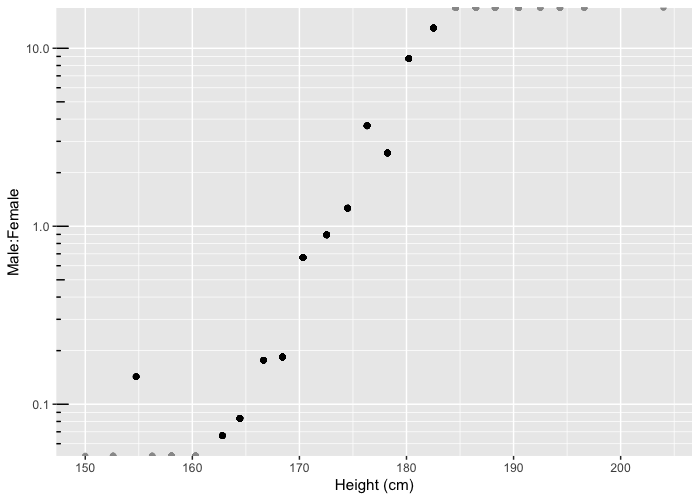

In [8]:
# plot odds in logarithmic scale

breaks <- 10^(-10:10)
minor_breaks <- rep(1:9, 21)*(10^rep(-10:10, each=9))

p_log_odds <- ggplot(props, aes(mean_height_bins, odds,
                  color=(!(odds==0 | is.infinite(odds))))) +
    geom_point() +
    xlab("Height (cm)") +
    ylab("Male:Female") +
    scale_y_log10(breaks=breaks, minor_breaks =minor_breaks) + 
    annotation_logticks(side="l") +
    scale_color_manual(values=c("#999999","#000000")) +  theme(legend.position = "none")

p_log_odds

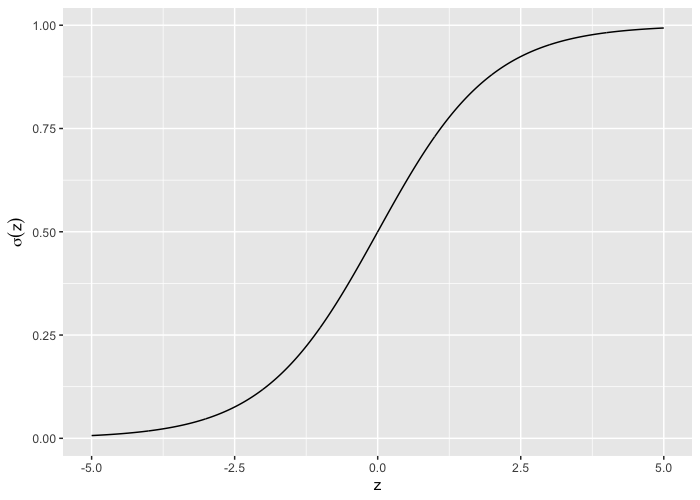

In [9]:
# plot sigmoid function

df <- data.table(z=seq(-5,5, length.out=1000))
df[,y:=1/(1+exp(-z))]
ggplot(df, aes(z, y)) +
  geom_line() +
  xlab("z") +
  ylab(expression(sigma(z)))

### 1. From Linear to Logistic Regression

Linear regression: derived with least squares criterion or with maximum likelihood criterion.

Likelihood of linear regression model:
- $p(y|X) = \Pi_{i} p(y_{i}|x_{i}$ (conditional independece)
- $p(y_{i}|x_{i}) = N(y_{i}|\mu_{i}, \sigma^{2})$
- $\mu_{i} = \beta_{0} + \sum_{j=1}^{p} \beta_{j} x_{i,j}$

Linear regression models: $\mu_{i} := E(y_{i}|x_{i,1}, \ldots, x_{i,p})$

---

Classification problem: approach by predicting probability (instead of unbounded continuos outcome) of class given some feature.

Model probability:
- with linear function: not ideal as predictions <0 or >1 possible
- with logistig function: ideal

Logistic regression models data:
- $p(y|X) = \Pi_{i} p(y_{i}|x_{i}$ (conditional independece)
- $p(y_{i}|x_{i}) = B(y_{i}|1,\mu_{i})$ (binomial distribution for 1 trial and probability $\mu_{i}$)
- $\mu_{i} := E(y_{i}|x_{i}) = \sigma(\beta_{0} + \sum_{j=1}^{p} \beta_{j} x_{i,j})$

Remark: binomial distribution for 1 trial equivalent to Bernoulli distribution (two outcomes, i.e. success or failure, with probabilities $\mu$ and $1-\mu$).

In logistic regression: $\mu = $ expectation of success class conditioned on feature, i.e. $E(y_{i}=1|x_{i,1}, \ldots, x_{i,p}) = \mu_{i}$.

Alternative to sigmoid: $\eta := \mathrm{logit}(\mu_{i}) = \beta_{0} + \sum_{j=1}^{p} \beta_{j} x_{i,j}$

---

*Conclusion*:

Classification problem: derive way to model with maximum likelihood criterion.

In [10]:
# --------------------

## Maximum Likelihood Estimates and Cross-Entropy Criterion

Estimate parameters of model via maximum likelihood criterion (as for linear regression):

$\mathrm{arg}\max_{\beta} \Pi_{i} p(y_{i}|x_{i}, \beta) = \mathrm{arg}\max_{\beta} \sum_{i} \log{(B(y_{i}|1,\mu_{i}(x_{i}, \beta)))} = \mathrm{arg}\min_{\beta} - \sum_{i}(y_{i} \log{(\mu_{i}(x_{i}, \beta))} + (1-y_{i}) \log{(1-\mu_{i}(x_{i}, \beta))})$

with cross-entropy between model predictions ($\mu_{i}$) and observations $y_{i}$: $- \sum_{i}(y_{i} \log{(\mu_{i}(x_{i}, \beta))} + (1-y_{i}) \log{(1-\mu_{i}(x_{i}, \beta))})$.

---

Problem: no analytical solution, use algorithms for computation.

In [11]:
# --------------------

## Logistic Regression as Generalized Linear Model (GLM)

GLM: generalize linear regression by allowing
1. linear model to be related to response variable via link function
2. magnitude of variance of each measurement to be function of its predicted value.

GLM exploit idea:
1. probability distribution from exponential family
    - logistic regression: Bernoulli
2. linear prediction $\eta = X\beta$
    - logistic regression: $\mathrm{logit}(\mu_{i}) = \eta_{i}=\beta_{0} + \sum_{j=1}^{p} \beta_{j}x_{i,j}$
3. link function $g$ s.t. $E(y)=\mu=g^{-1}(\eta)$
    - logistic regression: $g = \mathrm{logit}$, $g^{-1} = \mathrm{sigmoid}$
    
Remark: inverse of link function = activation function.

---

Further GLM examples: Poisson regression, Gamma regression.

### 1. Logistic Regression in R (`glm()`)

GLM: `glm` function.

Apply fitted model to data: `predict()` with parameter `type="response"` to get predicted probablities on natural scale instead of linear predictor $\eta$ (in logistic regression: logit of predicted probabilities).

In [12]:
logistic_fit <- glm(y ~ height, data=heights, family = "binomial")

heights[, mu_hat := predict(logistic_fit, heights, type="response")]
heights %>% head()

height,sex,mother,father,V5,y,height_bins,mean_height_bins,prop,odds,mu_hat
150,F,170,177,,0,"(149,151]",150.0,0,0,0.001269486
152,F,157,175,,0,"(151,153]",152.6,0,0,0.002259344
152,F,155,156,,0,"(151,153]",152.6,0,0,0.002259344
153,F,155,175,,0,"(151,153]",152.6,0,0,0.003013331
153,F,150,176,,0,"(151,153]",152.6,0,0,0.003013331
153,F,150,165,,0,"(151,153]",152.6,0,0,0.003013331


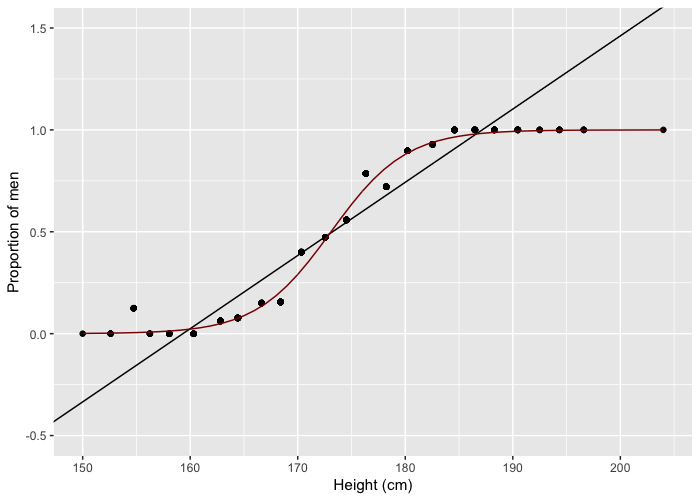

In [13]:
# plot linear regression (black) and logistic regression (red) line

ggplot(props, aes(mean_height_bins, prop)) +
  geom_point() +
  xlab("Height (cm)") +
  ylab("Proportion of men") +
  geom_abline(intercept = lm_fit$coef[1], slope = lm_fit$coef[2]) +
  geom_line(aes(height, mu_hat), col='darkred') +
  scale_y_continuous(limits=c(-0.5,1.5))

### 2. Overview Plot of Univariate Example

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


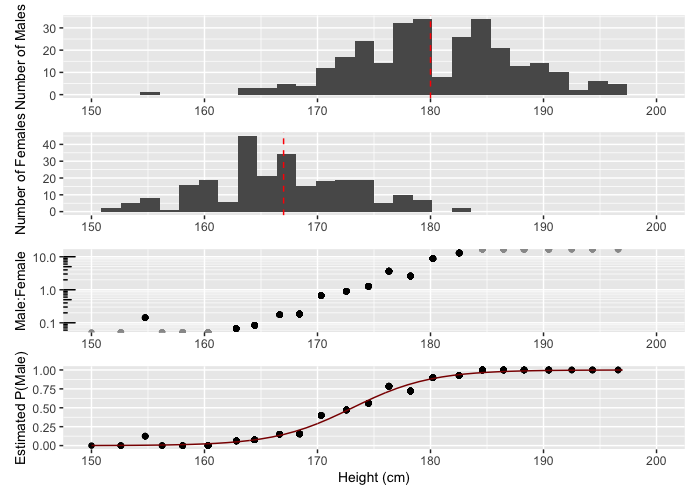

In [14]:
ys <- 10
p_hist_male <- ggplot(heights[sex=='M'], aes(height)) + 
  geom_histogram() +   
  scale_x_continuous(limits=c(150,200)) +
  geom_vline(aes(xintercept = median(height)),color="red", linetype="dashed", size=0.5) + 
  theme(axis.title.y = element_text(size = ys), axis.title.x=element_blank())+
  labs(x="Height (cm)", y="Number of Males") 
  
p_hist_female <- ggplot(heights[sex=='F'], aes(height)) + 
  geom_histogram() + 
  scale_x_continuous(limits=c(150,200)) +
  geom_vline(aes(xintercept = median(height)),color="red", linetype="dashed", size=0.5) + 
  theme(axis.title.y = element_text(size = ys), axis.title.x=element_blank())+
  labs(x="Height (cm)", y="Number of Females") 

p_fit_male <- ggplot(props, aes(mean_height_bins, prop)) +
  geom_point() +
  labs(x="Height (cm)", y="Estimated P(Male)") +
  geom_line(aes(height, mu_hat), col='darkred') +
  theme(axis.title.y = element_text(size = ys), axis.title.x = element_text(size = 10))+
  scale_x_continuous(limits=c(150,200))

p_log_odds <- p_log_odds + scale_x_continuous(limits=c(150,200)) +
  theme(axis.title.y = element_text(size = ys), axis.title.x=element_blank())


p_hist_male / p_hist_female / p_log_odds / p_fit_male

In [15]:
# --------------------

## Interpreting Logistic Regression Fit

### 1. Predicted Odds

Logit of predicted response/probability for certain input = predicted log odss for $y=1$ class on that input.

Hence get odds via exponential function.

In [16]:
# example for log odds
log_odds_178 <- predict(logistic_fit,data.table(height=178))
log_odds_178

# odds to be male if height is 178cm
exp(log_odds_178)

1 
1.41649

1 
4.122626

### 2. Coefficients of Logistic Regression

$\beta$ values: log odss ratios associated with increase by one unit of corresponding explanatory variable.

Hence get odss ratios via exponential function.

---

Log odds predicted as linear combination of features where coefficients are log odds ratios.

In example (predict sex from height): increasing height by $h$ centimeters changes log odds by $h \cdot 0.29$ (equivalently: multiplies odds by $e^{h \cdot 0.29} = 1.33^{0.29}$.

In [17]:
coef(logistic_fit)

OR_height <- exp(coef(logistic_fit)[2])
OR_height

(Intercept)      height 
-49.9769633   0.2887273

height 
1.334728

### 3. Effects on probabilities

Difference between linear and logistic regression: relationship between input and predicted value either linear or not linear.

---

*Example: increase of 5 centimeters*

Start at odds 1:1: probability is 0.5, corresponding height is $\log{\mathrm{odds}} = \beta_{0} + \beta_{1} \cdot \mathrm{height}$ with coefficients of logistig regression $\beta_{0}, \beta_{1}$.

Result: height value is $173.6$cm (note: in former data set, not this one :/)

Note: steepest increase of logistic curve = predicted probability of 0.5.

In [18]:
# increase in 5cm -> probability:
prob_5 <- predict(logistic_fit, data.table(height =173.6+5), type="response")
prob_5
# increse in probability of around 0.33

# increase in 10cm -> probability:
prob_10 <- predict(logistic_fit, data.table(height =173.6+10), type="response")
prob_10
# increse in probability of around 0.33+0.12

1 
0.8305776

1 
0.9540588

### 4. Class Imbalance

Situation: one class has substancially more instances then other.

---

Observations in example:
- Curve shifted to right, i.e. probability of being male is lower than before.
- In logit of predicted response: intercept lower, lines parallel, i.e. estimated log odds are lower.

---

Why can effects be seen on intercept?

Proportion among male per stratum independent of number of males, but ratio of males over females scales with number of males.

In [19]:
# create imbalances data set with about 20% males, 80% females
set.seed(123)
imbalanced_heights <- heights[-sample(which(sex=="M"), 100)]
imbalanced_heights[, table(sex)]

sex
  F   M   W   А 
253 189   0   0 

In [20]:
# logistic regression
logistic_fit_imbalanced <- glm(y ~ height, data=imbalanced_heights, family = "binomial")
logistic_fit_imbalanced


Call:  glm(formula = y ~ height, family = "binomial", data = imbalanced_heights)

Coefficients:
(Intercept)       height  
   -51.1681       0.2928  

Degrees of Freedom: 441 Total (i.e. Null);  440 Residual
Null Deviance:	    603.4 
Residual Deviance: 299.1 	AIC: 303.1

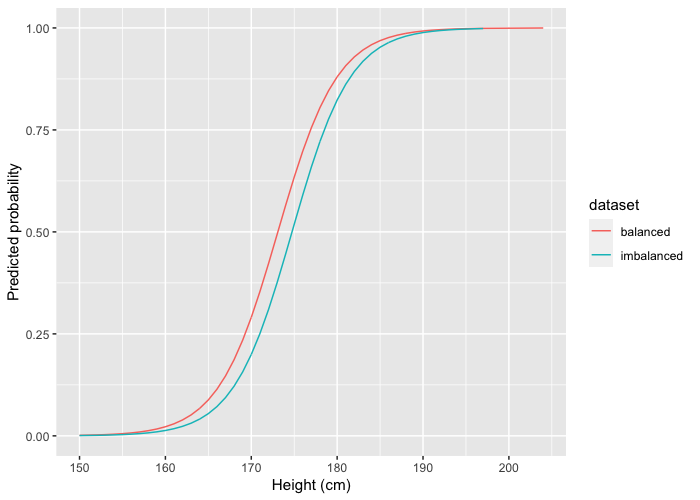

In [21]:
# plot new (imbalanced data) and former (normal data) logistic fit
imbalanced_props <- imbalanced_heights[, prop:=mean(sex=="M"), by=height]

imbalanced_props[, mu_hat := predict(logistic_fit_imbalanced, imbalanced_props, type="response")]

imbalanced_props[, dataset:="imbalanced"]
props[, dataset:="balanced"]

rbind(imbalanced_props, props, fill=T) %>%
ggplot(aes(height, mu_hat, color=dataset)) +
  geom_line() +
  xlab("Height (cm)") +
  ylab("Predicted probability")

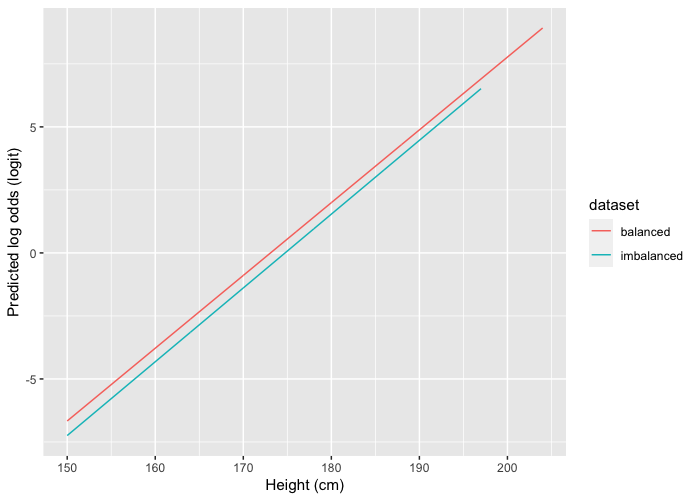

In [22]:
imbalanced_props[, logistic_logit := predict(logistic_fit_imbalanced, imbalanced_props)]
props[, logistic_logit:=predict(logistic_fit, props)]

rbind(imbalanced_props, props, fill=T) %>%
ggplot(aes(height, logistic_logit, color=dataset)) +
  geom_line() +
  xlab("Height (cm)") +
  ylab("Predicted log odds (logit)")

### 5.  Multiple Logistic Regression

Allow several input variables.

In [23]:
# example predict sex given height of students and of the parents

multi_logistic_fit <- glm(y ~ height + mother + father, data=heights, family = "binomial")
multi_logistic_fit

# result: increase in height -> increase of probability (as in univariate fit)


Call:  glm(formula = y ~ height + mother + father, family = "binomial", 
    data = heights)

Coefficients:
(Intercept)       height       mother       father  
   -26.3206       0.5090      -0.1835      -0.1779  

Degrees of Freedom: 541 Total (i.e. Null);  538 Residual
Null Deviance:	    749 
Residual Deviance: 247.4 	AIC: 255.4

In [24]:
# --------------------

## Assessing Performance of Classifier

### 1. Classification with Logistic Regression

Logistic regression predicts probability, hence uncertainty in prediction.

Hard classification: if $\mu > 0.5$ (or $\eta > 0$) predict class 1, else predict class 0. (hint: use `round()` in R)

In [25]:
heights[, y_multi_pred := round(predict(multi_logistic_fit, heights, type="response"))]
heights[, table(y, y_multi_pred)]

   y_multi_pred
y     0   1
  0 229  24
  1  28 261

### 2. Confusion Matrix

(Table created above is an example of a confusion matrix.)

$\newcommand\T{\Rule{0pt}{1em}{.3em}}
\begin{array}{c|c|c|}
 & \text{positive} (\textit{predicted class}) & \text{negative} (\textit{predicted class}) \\\hline
  \text{positive} (\textit{true class}) & \text{TP} & \text{FN} \\\hline
  \text{negative} (\textit{true class}) & \text{FP} & \text{TN} \\\hline
\end{array}$

Remark: FP = type I error, FN = type II error.

### 3. Classification Performance Metrics

Quality metrics based on confusion table.

1. Sensitivity ("true positive rate"): $\frac{\text{TP}}{\text{P}} = \frac{\text{TP}}{\text{TP} + \text{FN}}$
2. Specificity ("true negative rate"): $\frac{\text{TN}}{\text{N}} = \frac{\text{TN}}{\text{TN} + \text{FP}}$
3. Precision ("positive prediction value"): $\frac{\text{TP}}{\text{TP} + \text{FP}}$

Reminder: False Discovery Rate (FDR) $= E[\frac{\text{FP}}{\text{TP} + \text{FP}}] = E[1 - \frac{\text{TP}}{\text{TP} + \text{FP}}] = 1- E[\mathrm{Precision}]$ related to precision!

### 4. Choosing Classification Cutoff

Often: classification methods return quantitative score, not assign class, e.g. logistic regression (return probability) or SVM.

Therefore: set "cutoff" above which input is classified as "positive", e.g. $\mu > 0.5$ (or $\eta > 0$).

Note: choosing cutoff = trade-off between sensitivity and specificity.

Careful: choice influences preformance metrics.

### 5. ROC Curve (`geom_roc()`, `calc_auc()`)

ROC (receiver operating characteristic): way to evaluate quality of binary classifier at different cutoff.

POC describes:
1. false positive rate on x-axis: $\text{FPR} = \frac{\text{FP}}{\text{N}} = \frac{\text{FP}}{\text{FP} + \text{TN}}$ (1-specificity).
2. true positive rate on y-axis: $\text{TPR} = \frac{\text{TP}}{\text{P}} = \frac{\text{TP}}{\text{TP} + \text{FN}}$ (sensitivity).

Interpretation: points along line represent cutoff value. If
- all instances classified as positive (cutoff=0): $\text{FPR} = \text{TPR} = 1$
- all instances classified as pnegative (cutoff=1): $\text{FPR} = \text{TPR} = 0$

Note: ROC curve of random classifier approximates diagonal (`geom_abline()`)

---

Alternative performance measure: AUC (area under ROC curve).

Interpretation:
- AUC = 1: model can perfectly distinguish between positive and negative classes.
- AUC = 0.5: classifier model not better tha random classification.

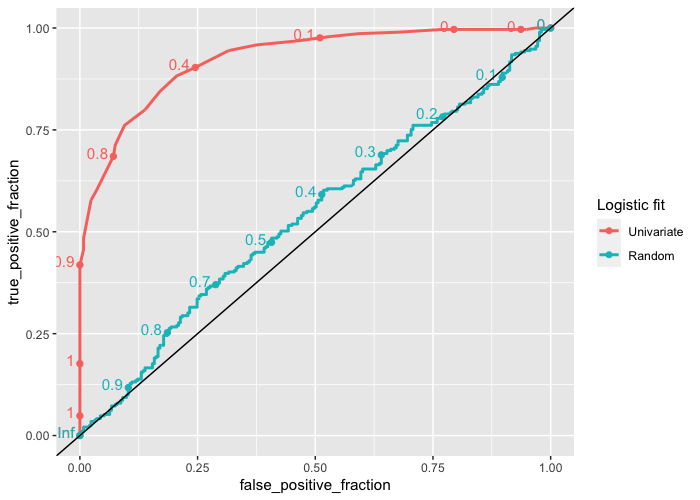

In [26]:
# ROC curve for univariate logistic regression model fitted on height
# and ROC curve of random classifier
heights[, random_scores:=runif(.N)]

heights_melted <- heights[, .(y, mu_hat, random_scores)] %>% 
  melt(id.vars="y", variable.name = "logistic_fit", value.name="response")
  
ggroc <- ggplot(heights_melted, aes(d=y, m=response, color=logistic_fit)) +
            geom_roc() +
            scale_color_discrete(name = "Logistic fit", labels = c("Univariate", "Random")) +
            geom_abline()
ggroc

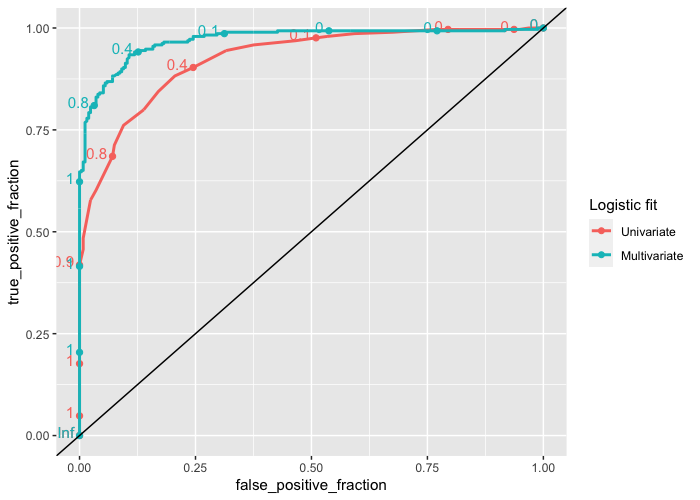

In [27]:
# ROC curve for univariate and multivariate logistic regression model fitted on height
heights[, multi_logistic_mu_hat := predict(multi_logistic_fit, heights, type = "response")]

heights_melted <- heights[, .(y, mu_hat, multi_logistic_mu_hat)] %>% 
  melt(id.vars="y", variable.name = "logistic_fit", value.name="response")
  
ggroc <- ggplot(heights_melted, aes(d=y, m=response, color=logistic_fit)) +
            geom_roc() +
            scale_color_discrete(name = "Logistic fit", labels = c("Univariate", "Multivariate")) +
            geom_abline()
ggroc

In [28]:
calc_auc(ggroc)

# result: multivariate better!

PANEL,group,AUC
1,1,0.9232600
1,2,0.9700822


### 6. Precision Recall Curve (`pr.curve()`)

Precision recall curve: plot precision against recall (for inspection of performances).

Similar ROC curves $\neq$ similar precision recall curves.

Possible reason for non-similarity: lower precision for same recall due to imbalance in data set.

AUC
0.9264278


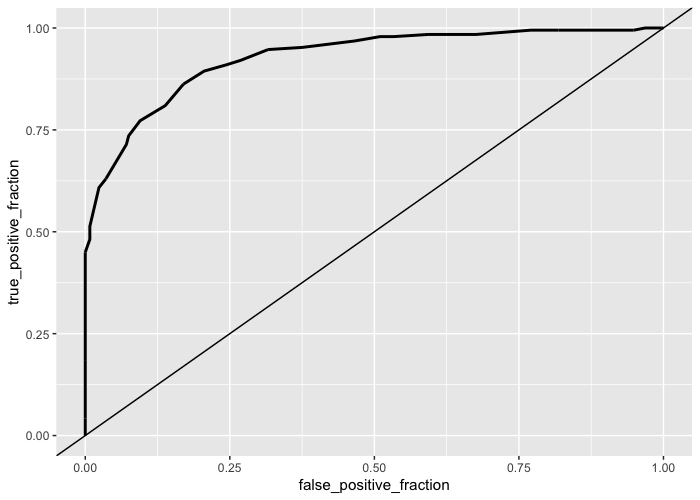

In [29]:
# ROC curve and AUC value of imbalanced data set

imbalanced_heights[, mu_hat:=predict(logistic_fit_imbalanced, imbalanced_heights, type="response")]
ggroc<- ggplot(imbalanced_heights, aes(d=y, m=mu_hat)) +
            geom_roc(n.cuts=0) +
            geom_abline()
ggroc

calc_auc(ggroc)["AUC"]

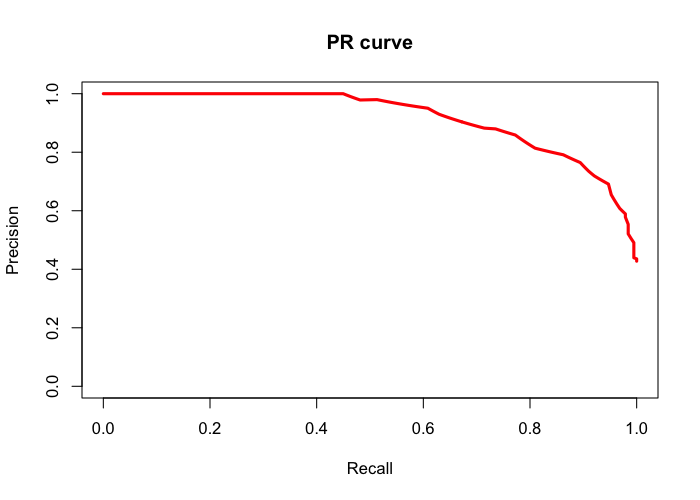

In [30]:
PRROC_obj <- pr.curve(scores.class0 = imbalanced_heights$mu_hat, weights.class0=imbalanced_heights$y,
                       curve=TRUE)
plot(PRROC_obj, auc.main=FALSE , color=2)

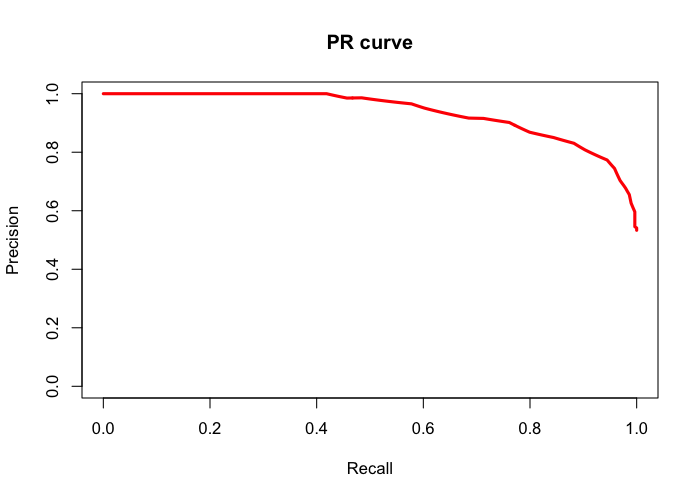

In [31]:
PRROC_obj <- pr.curve(scores.class0 = heights$mu_hat, weights.class0=heights$y,
                       curve=TRUE)
plot(PRROC_obj, auc.main=FALSE , color=2)

##### End of Section 11!